<h1>Universidad Politécnica Salesiana</h1>
<h2>Minería de Datos</h2>
<h3>Realizado por: Rodolfo Bojorque</h3>

<h2>Redes neuronales</h2>

In [1]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

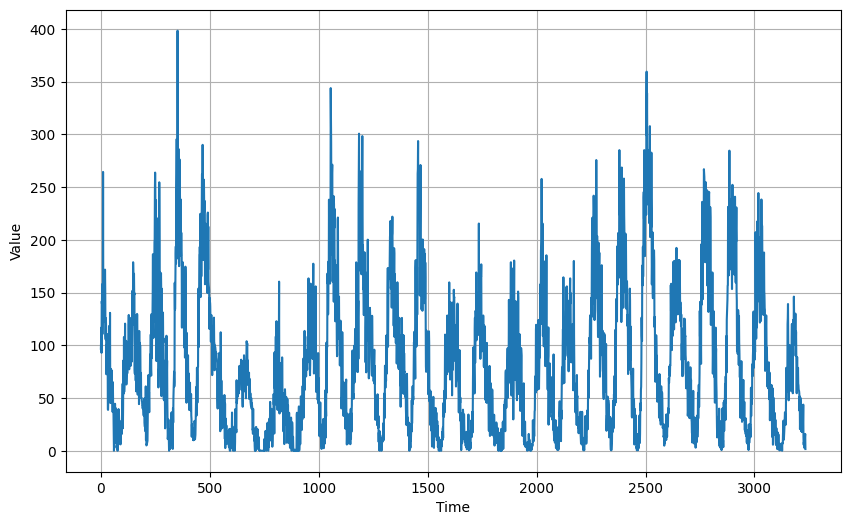

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
time_step = []
sunspots = []

with open('./sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [3]:
print(len(series))

3235


In [4]:
split_time = 3000
time_train = time[:split_time]
print("time_train=",len(time_train))
x_train = series[:split_time]
print("x_train=",len(x_train))
time_valid = time[split_time:]
print("time_valid=",len(time_valid))
x_valid = series[split_time:]
print("x_valid=",len(x_valid))

time_train= 3000
x_train= 3000
time_valid= 235
x_valid= 235


Parámetros de las series temporales:
- window_size: Define el tamaño de la ventana para los entrenamientos
- batch_size: Es el tamaño del lote para el entranemiento con descenso del gradiente estocástivo
- shuffle_buffer_size: 

In [5]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

La función <i>windowed_dataset</i> sirve para definir el tamaño de ventana para los entrenamientos

In [6]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) #Utilizamos la función expand_dims para expandir las dimensiones de las series
                                            #antes de procesarlas
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

La función <i>model_forecast</i> sirve para encontrar el pronóstico según el tamaño de la ventana

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
print("Window size=",window_size," batch_size=",batch_size)
tf.keras.backend.clear_session()
tf.random.set_seed(100)#Parámetro para replicabilidad de experimentos
np.random.seed(100)#Parámetro para replicabilidad de experimentos
#window_size = 64
#batch_size = 256 #Este parámetro se puede modificar para los entrenamientos con descenso del gradiente estocástico.
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) #Esta función fue definida arriba
#print(train_set)
#print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, #Utilizamos una convolución 1D con tamaño de ventana=5
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), #Aquí dejamos lista la entrada para trabajar con LSMT
                                            #Esto requiere ser actualizado en la funcion de ventana
  tf.keras.layers.LSTM(64, return_sequences=True), #Usamos una capa LSMT, Ojo sequences=True para que devuelva todas las y
  tf.keras.layers.LSTM(64, return_sequences=True), #Usamos otra capa LSMT,, Ojo sequences=True para que devuelva todas las y
  tf.keras.layers.Dense(30, activation="relu"), #Una capa de conexiones densa de 30 neuronas
  tf.keras.layers.Dense(10, activation="relu"), #Otra capa densa de 10 neuronas
  tf.keras.layers.Dense(1), #Otra capa densa de una neurona para la salida
  tf.keras.layers.Lambda(lambda x: x * 400) #La capa lambda nos permite hacer operaciones sobre una capa (x*400)
                                            #En este caso la multiplicación ayuda a acelerar el aprendizaje
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#Entrenamos el modelo con 100 epochs Este parámetro también lo puede configurar
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule]) 


Window size= 30  batch_size= 32

Epoch 1/100


C:\Users\lcres\PycharmProjects\MPI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 99.2238 - mae: 99.7205 - learning_rate: 1.0000e-08
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 60.0943 - mae: 60.5917

C:\Users\lcres\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 50.5188 - mae: 51.0158 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 39.9240 - mae: 40.4205 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 38.5988 - mae: 39.0948 - learning_rate: 1.4125e-08
Epoch 5/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 37.4086 - mae: 37.9049

KeyboardInterrupt: 

In [13]:
print(history.history.keys())


dict_keys(['loss', 'mae', 'learning_rate'])


(1e-08, 0.0001, 0.0, 60.0)

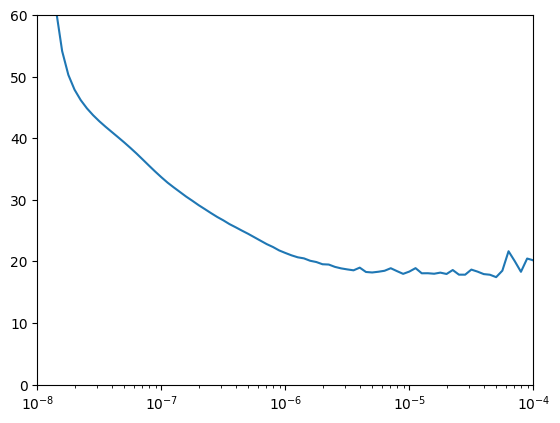

In [14]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


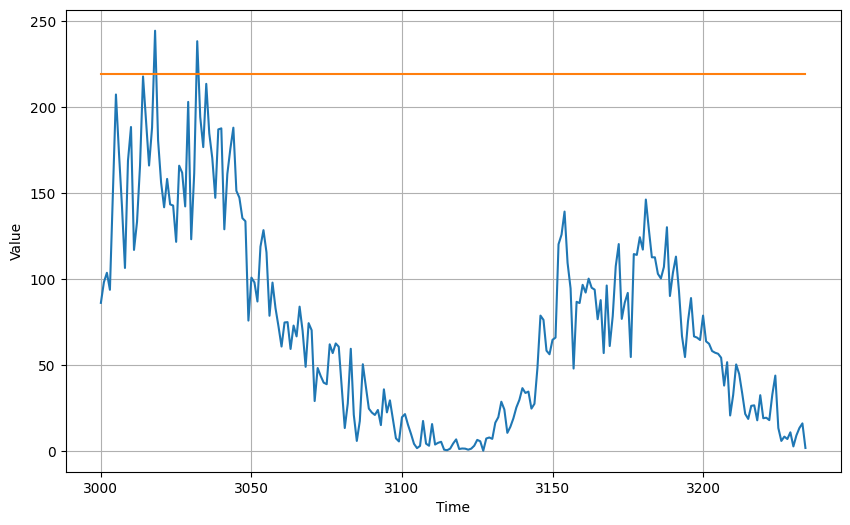

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

<Figure size 640x480 with 0 Axes>

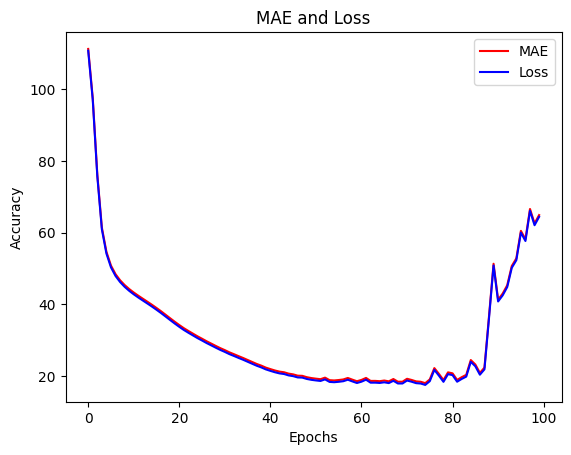

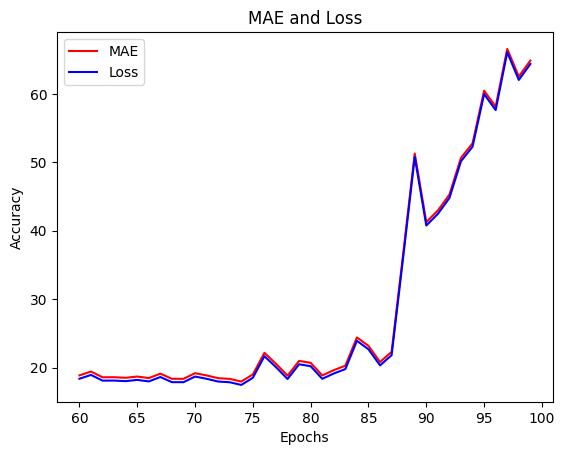

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperamos la lista de resultados en training y test
# Ajustado para cada training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Obtener el número de epochs

#------------------------------------------------
# Plot MAE y Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[60:]
mae_zoom = mae[60:]
loss_zoom = loss[60:]

#------------------------------------------------
# Plot Zoomed MAE y Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

Como pudimos apreciar el entrenamiento anterior no resulta para nada exitoso.
Ahora probamos otra configuración:
- batch_size=100
- window size=60
- Pero ahora relizaremos 500 epochs

In [10]:
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()
tf.random.set_seed(100)
np.random.seed(100)

# Suponiendo que windowed_dataset es una función previamente definida
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, batch_size=100)

# Evaluación del modelo en los datos de validación (suponiendo que x_val y y_val están definidos)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
val_loss, val_mae = model.evaluate(val_set)

print(f"Validation MAE: {val_mae}")

# Condición para asegurar que MAE sea mínimo del 80%
if val_mae < 0.8:
    print("Modelo entrenado con éxito con MAE menor a 0.8")
else:
    print("El MAE del modelo es mayor a 0.8, considere ajustar los hiperparámetros y la arquitectura.")


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 46.0012 - mae: 46.4975
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 25.0077 - mae: 25.5022
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 21.6012 - mae: 22.0947
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 20.0849 - mae: 20.5776
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 19.3326 - mae: 19.8255
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 19.0291 - mae: 19.5216
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 18.2669 - mae: 18.7590
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 18.2541 - mae: 18.7461
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 17.9911 - mae: 18.4828
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 18.0077 - mae: 18.4998
Epoch 11/100
 3/30 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 17.8417 - mae: 18.3332

KeyboardInterrupt: 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Tu conjunto de datos dividido
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Asumiendo que tienes un tamaño de ventana y buffer de shuffle definidos
window_size = 60
shuffle_buffer_size = 1000

# Crear el conjunto de entrenamiento y validación
train_set = windowed_dataset(x_train, window_size, batch_size=100, shuffle_buffer=shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=100, shuffle_buffer=shuffle_buffer_size)

def create_model(optimizer='adam', learning_rate=0.001, units=60, dropout_rate=0.0):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=units, kernel_size=5,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(units, return_sequences=True),
        tf.keras.layers.LSTM(units, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(units//2, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=["mae"])
    return model

# Convertir tu función create_model en un KerasRegressor
model = KerasRegressor(model=create_model, optimizer='adam', learning_rate=0.001, units=60, dropout_rate=0.0, epochs=50, batch_size=100, verbose=0)

# Definir los parámetros de la búsqueda en cuadrícula
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'units': [60, 128],
    'dropout_rate': [0.0, 0.2, 0.4]
}

# Crear el GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')

# Ajustar el GridSearchCV a los datos
grid_result = grid.fit(np.array(x_train).reshape(-1, 1), np.array(x_train))

# Resumen de los resultados
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean} ({std}) with: {param}")


C:\Users\lcres\PycharmProjects\MPI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lcres\PycharmProjects\MPI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lcres\PycharmProjects\MPI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

Best: -53.118127114868166 using {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'units': 60}
-53.292916028849284 (6.5857289965709125) with: {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': 'adam', 'units': 60}
-53.60453298924764 (6.480830448552959) with: {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': 'adam', 'units': 128}
-53.118127114868166 (6.891103662223594) with: {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'units': 60}
-53.698108240763354 (6.491457605525053) with: {'dropout_rate': 0.0, 'learning_rate': 0.0001, 'optimizer': 'sgd', 'units': 128}
-54.18224313176473 (6.104197178803354) with: {'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 60}
-54.212977024587 (6.074547365808395) with: {'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 128}
-54.088327099100745 (6.117902677243834) with: {'dropout_rate': 0.0, 'learning_rate': 0.001, 'optimizer': 'sgd', 'units': 60}
-54.23